In [1]:
import cv2
import pandas as pd
import glob
# Open the image file
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
images = glob.glob("/app/segment/dataset/train/*/labels/*")
groups = {}
for i in images:
    g = i.split("/")[5]
    if g not in groups:
        groups[g] = []
    groups[g].append(i)

In [20]:
z = list(map(lambda x: int(x.split("labels/")[-1].split(".")[0]),groups["kidney_3_dense"]))

In [21]:
len(z),max(z),min(z)

(501, 996, 496)

In [3]:
{x:len(groups[x]) for x in groups}

{'kidney_1_dense': 2279,
 'kidney_1_voi': 1397,
 'kidney_2': 2217,
 'kidney_3_dense': 501,
 'kidney_3_sparse': 1035}

# slice random plane from image and mask

In [4]:
k = "kidney_3_dense"
masks = []
images = []
for image_path in tqdm(groups[k]):
    images.append(cv2.imread(image_path.replace("labels","images"),cv2.IMREAD_GRAYSCALE))
    masks.append(cv2.imread(image_path,cv2.IMREAD_GRAYSCALE))
masks = np.stack(masks,2)
images = np.stack(images,2)
# np.save(f"{k}_img.npy",images)

100%|██████████| 501/501 [00:05<00:00, 91.47it/s]


In [ ]:
import numpy as np
import random

def sample_plane(images, masks):
    # Step 1: Determine the dimensions
    x, y, z = images.shape
    
    # Step 2: Randomly choose one of the three dimensions (0 for x, 1 for y, 2 for z)
    axis = random.choice([0, 1, 2])

    # Step 3: Randomly select an index along the chosen axis
    if axis == 0: # Sampling along x-axis
        index = random.randint(0, x-1)
        plane_images = images[index, :, :]
        plane_masks = masks[index, :, :]
    elif axis == 1: # Sampling along y-axis
        index = random.randint(0, y-1)
        plane_images = images[:, index, :]
        plane_masks = masks[:, index, :]
    else: # Sampling along z-axis
        index = random.randint(0, z-1)
        plane_images = images[:, :, index]
        plane_masks = masks[:, :, index]

    # Return the sampled planes
    return plane_images, plane_masks

In [ ]:
import numpy as np
import random

def random_plane_intersection_optimized(images, masks, plane_thickness=1):
    x, y, z = images.shape

    # Random normal vector
    normal = np.random.randn(3)
    normal /= np.linalg.norm(normal)  # Normalize

    # Random point within bounds
    point = np.array([random.uniform(0, x), random.uniform(0, y), random.uniform(0, z)])

    # Create a coordinate grid
    X, Y, Z = np.meshgrid(np.arange(x), np.arange(y), np.arange(z), indexing='ij')

    # Calculate distance of all points to the plane
    distances = np.abs(normal[0] * (X - point[0]) + normal[1] * (Y - point[1]) + normal[2] * (Z - point[2]))

    # Find points close to the plane
    mask = distances < plane_thickness

    # Extract values from images and masks
    plane_images = np.where(mask, images, 0)
    plane_masks = np.where(mask, masks, 0)

    # Summing over two axes to collapse into a 2D array
    # The choice of axes to sum over depends on the orientation of the plane
    plane_images_2d = np.sum(plane_images, axis=0)
    plane_masks_2d = np.sum(plane_masks, axis=0)

    return plane_images_2d, plane_masks_2d


In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm

def apply_mask_and_save(images, masks, base_folder='./output'):
    # Create base folder if it doesn't exist
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)

    # Dimensions
    x_size, y_size, z_size = images.shape

    # Iterate over each dimension
    for dim, size in zip(['x', 'y', 'z'], [x_size, y_size, z_size]):
        # Create a folder for the dimension
        dim_folder = os.path.join(base_folder, dim)
        if not os.path.exists(dim_folder):
            os.makedirs(dim_folder)

        for i in tqdm(range(size), desc=f"Processing along {dim}-axis"):
            if np.random.rand()>0.1:
                continue
            # Slice the image and mask
            if dim == 'x':
                slice_image = images[i, :, :]
                slice_mask = masks[i, :, :]
            elif dim == 'y':
                slice_image = images[:, i, :]
                slice_mask = masks[:, i, :]
            else:
                slice_image = images[:, :, i]
                slice_mask = masks[:, :, i]

            # Apply histogram equalization
            equalized_image = cv2.equalizeHist(slice_image)

            # Convert to color (3 channels)
            color_image = cv2.cvtColor(equalized_image, cv2.COLOR_GRAY2BGR)

            # Overlay mask
            mask_color = cv2.cvtColor(slice_mask, cv2.COLOR_GRAY2BGR)
            overlay = cv2.addWeighted(color_image, 0.5, mask_color, 0.5, 0)

            # Downsample the image by a factor of 4
            downsampled_image = cv2.resize(overlay, (overlay.shape[1] // 4, overlay.shape[0] // 4), interpolation=cv2.INTER_AREA)

            # Save the image
            cv2.imwrite(os.path.join(dim_folder, f'{dim}_slice_{i}.png'), downsampled_image)
# apply_mask_and_save(images,masks,"./kidney2")

Processing along z-axis: 100%|██████████| 1510/1510 [00:03<00:00, 494.37it/s]


# visualize all images, downsampled

In [4]:
for k in groups:
    for image_path in tqdm(groups[k]):
        img = cv2.imread(image_path.replace("labels","images"),cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img,(img.shape[1]//4,img.shape[0]//4))
        mask = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask,(mask.shape[1]//4,mask.shape[0]//4))
        img = cv2.equalizeHist(img)*0.5 + 0.5*mask
        fname = "/".join(image_path.split("/")[-3:]).replace(".tif",".png")
        os.makedirs(os.path.join("./tmp",os.path.split(fname)[0]),exist_ok=True)
        cv2.imwrite(os.path.join("./tmp",fname),img)

 18%|█▊        | 403/2279 [00:02<00:12, 155.56it/s]


KeyboardInterrupt: 

In [ ]:
!zip -r tmp.zip ./tmp

# similarity analysis

In [ ]:
masks = {}
for image_path in tqdm(groups["kidney_1_dense"]):
    mask = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    mask = (cv2.resize(mask,(mask.shape[1]//8,mask.shape[0]//8))>0).astype(np.uint8)
    masks[image_path] = mask.reshape(-1)

In [ ]:
# Calculate cosine similarity
cos_similarities = cosine_similarity(list(masks.values()))
np.fill_diagonal(cos_similarities,-1)
# Find the max cosine similarity for each image (excluding self-similarity)
max_cos_sim = cos_similarities.max(1)

# Plot histogram
plt.hist(max_cos_sim, bins=50)
plt.xlabel('Maximum Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Maximum Cosine Similarity with Other Images')
plt.show()

In [ ]:
plt.imshow( cv2.resize(img,(img.shape[1]//4,img.shape[0]//4)))

# image visualization

In [5]:
{k:len(v) for k,v in groups.items()}

{'kidney_1_dense': 2279,
 'kidney_1_voi': 1397,
 'kidney_2': 2217,
 'kidney_3_dense': 501,
 'kidney_3_sparse': 1035}

kidney_1_dense


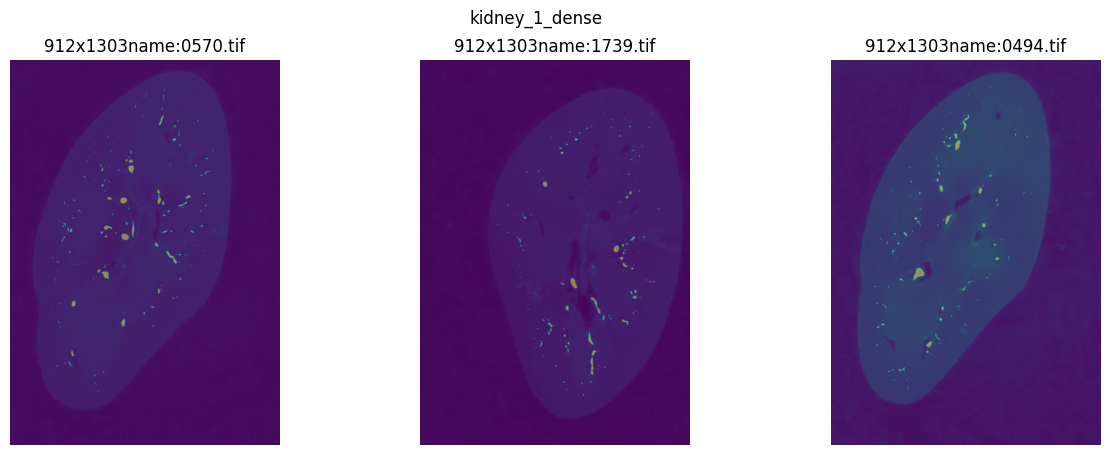

kidney_1_voi


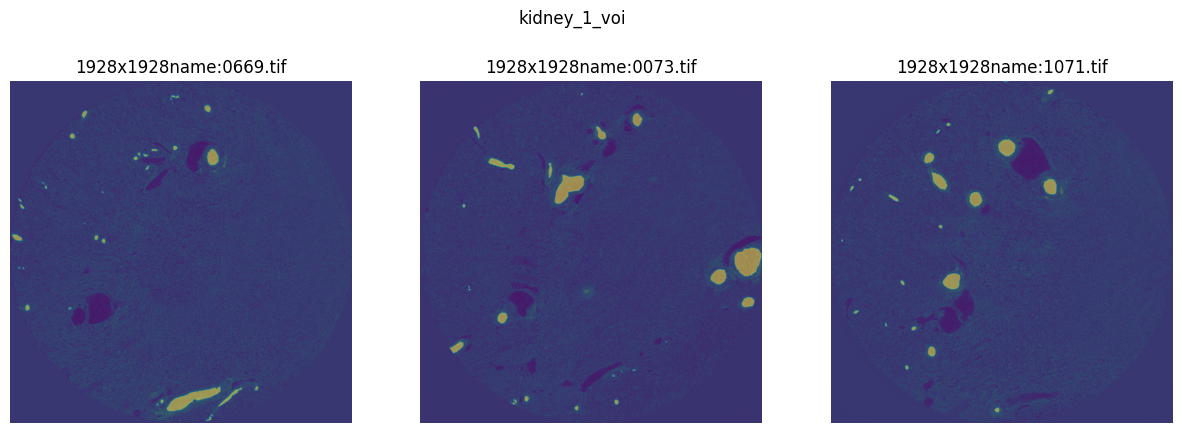

kidney_2


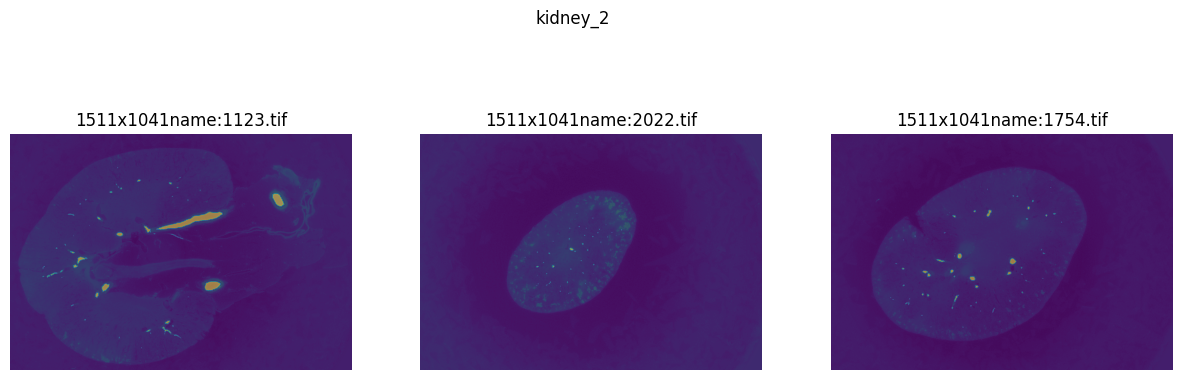

kidney_3_dense


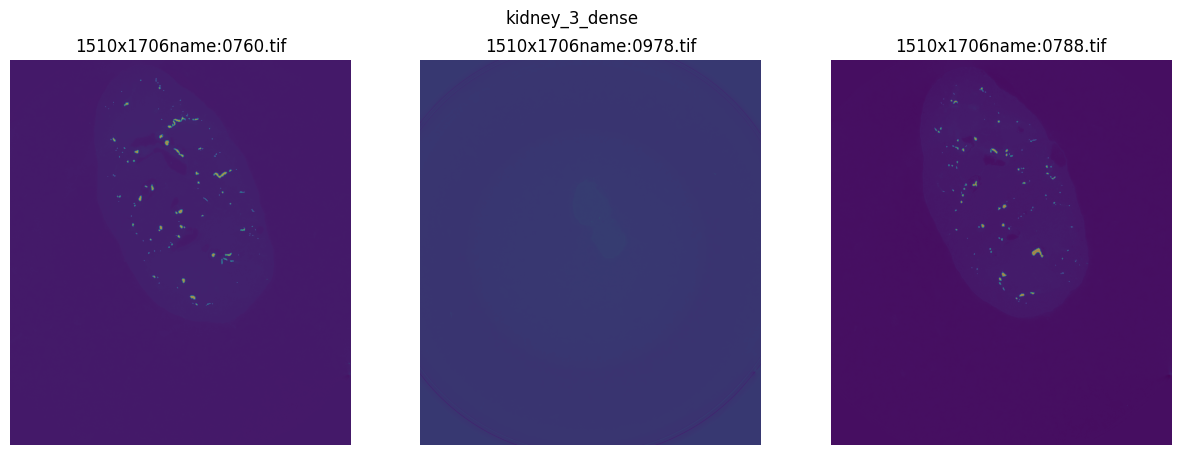

kidney_3_sparse


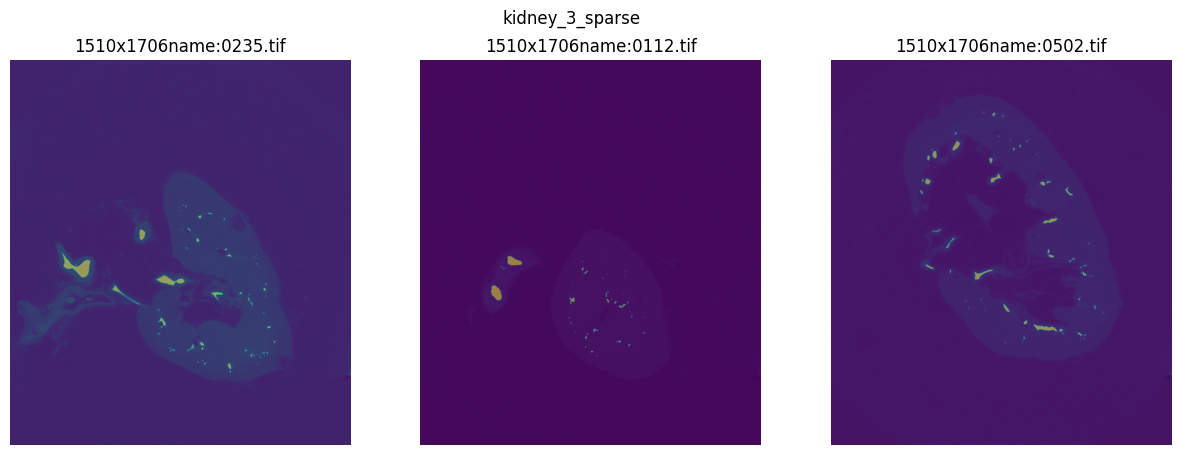

In [6]:
def display_random_images(image_dict):
    for category, images in image_dict.items():
        sampled_images = random.sample(images, min(3, len(images)))
        plt.figure(figsize=(15, 5))
        plt.suptitle(category)
        print(category)
        for i, image_path in enumerate(sampled_images, 1):
            img = cv2.imread(image_path.replace("labels","images"),cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)

            plt.subplot(1, 3, i)
            plt.imshow(img)
            plt.imshow(mask, cmap='viridis',alpha=0.5)
            plt.title(f"{img.shape[1]}x{img.shape[0]}"+f"name:{os.path.split(image_path)[-1]}")  # Image dimensions as title
            plt.axis('off')
        plt.show()

display_random_images(groups)

# visualize 3d plot

In [ ]:
import cv2
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio # to save the graphics as html
import pyvista as pv

for k,v in groups.items():
    mask=[]
    for i,f in tqdm(enumerate(sorted(v))):
        if np.random.rand()>0.2:
            continue
        v = cv2.imread(f,cv2.IMREAD_GRAYSCALE)
        v = cv2.resize(v,(v.shape[1]//3,v.shape[0]//3))
        mask.append(v)
    mask = np.stack(mask)
    import numpy as np
    import plotly.graph_objects as go
    import plotly.express as px
    x,y,z = np.where(mask > 100)
    data = pd.DataFrame({'x': x,
                        'y': y,
                        'z': z})
    data = data.sample(30000)

    # Creating a scatter plot for the points
    fig = px.scatter_3d(data,x="x", y="y", z="z")
    fig.update_traces(marker=dict(size=2), selector=dict(mode='markers'))
    fig.update_traces(marker=dict(opacity=0.5), selector=dict(mode='markers'))
    fig.update_layout(title=k)
    fig.show()

# save stacked 3d images

In [15]:
# ROOT="/app/segment/dataset/train_3d"
# os.makedirs(os.path.join(ROOT,"images"),exist_ok=True)
# os.makedirs(os.path.join(ROOT,"masks"),exist_ok=True)
# for k in groups:
#     masks = []
#     images = []
#     for image_path in tqdm(sorted(groups[k])):
#         images.append(cv2.imread(image_path.replace("labels","images"),cv2.IMREAD_GRAYSCALE))
#         masks.append(cv2.imread(image_path,cv2.IMREAD_GRAYSCALE))
#     masks = np.stack(masks,2)
#     images = np.stack(images,2)
#     np.save(os.path.join(ROOT,"images",f"{k}.npy"),images)
#     np.save(os.path.join(ROOT,"masks",f"{k}.npy"),masks)

100%|██████████| 1035/1035 [00:10<00:00, 95.30it/s]


In [23]:
import glob

In [30]:
[(a,b,[0]) for a,b in zip(glob.glob("/app/segment/dataset/train_3d/images/*"),glob.glob("/app/segment/dataset/train_3d/masks/*"))]

[('/app/segment/dataset/train_3d/images/kidney_1_dense.npy',
  '/app/segment/dataset/train_3d/masks/kidney_1_dense.npy',
  [0]),
 ('/app/segment/dataset/train_3d/images/kidney_1_voi.npy',
  '/app/segment/dataset/train_3d/masks/kidney_1_voi.npy',
  [0]),
 ('/app/segment/dataset/train_3d/images/kidney_2.npy',
  '/app/segment/dataset/train_3d/masks/kidney_2.npy',
  [0]),
 ('/app/segment/dataset/train_3d/images/kidney_3_dense.npy',
  '/app/segment/dataset/train_3d/masks/kidney_3_dense.npy',
  [0]),
 ('/app/segment/dataset/train_3d/images/kidney_3_sparse.npy',
  '/app/segment/dataset/train_3d/masks/kidney_3_sparse.npy',
  [0])]